# Ласкаво прошу до першої частини домашнього завдання №2!

В ній, ви імплементуєте алгоритм Гістограм Орієнтованих Градієнтів та навчите класифікатор зображень на наборі даних CIFAR10.


In [1]:
"""
In this task, you are required to implement the Histograms of Oriented Gradients (HOG) algorithm.
"""

# Fix for OpenMP warning
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import numpy as np
import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from lib.feature_extractor import FeatureExtractor, BaselineFeatureExtractor
from lib.vis_utils import visualize_dataset_images, visualize_predictions
from lib.dataset import CIFAR10

from multiprocessing import Pool

%load_ext autoreload
%autoreload 2

In [2]:
def calc_accuracy(model, feats, labels):
    preds = model.predict(feats)
    return np.mean(labels == preds)

In [3]:
cifar10 = CIFAR10()
(
    images_train, labels_train,
    images_val, labels_val,
    images_test, labels_test
) = cifar10.load_dataset()

CIFAR10 found.


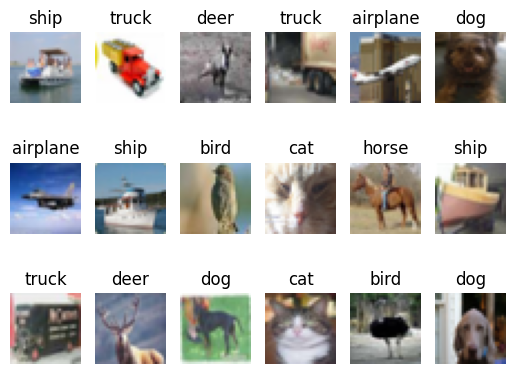

In [4]:
visualize_dataset_images(images_val[:18], labels_val[:18], cifar10.LABEL_NAMES)

# Baseline
Спочатку розглянемо `BaselineFeatureExtractor`. Його імплементація знаходиться в файлі `lib/feature_extractor.py`
Це дуже простий екстрактор ознак, який обчислює середні значення та стандартні відхилення для блоків пікселів 4х4, після чого конкатенує їх у фінальний вектор ознак.

In [5]:
baseline_extractor = BaselineFeatureExtractor()
feats_train = baseline_extractor.extract(images_train)
feats_val = baseline_extractor.extract(images_val)
feats_test = baseline_extractor.extract(images_test)

48999it [00:18, 2609.55it/s]
999it [00:01, 718.26it/s]
999it [00:01, 834.02it/s] 


Для класифікації зображень використаємо алгоритм К найближчих сусідів.

In [6]:
knn = KNeighborsClassifier(n_neighbors=5)
knn = knn.fit(X=feats_train, y=labels_train)

In [7]:
tr_acc = calc_accuracy(knn, feats_train, labels_train)
val_acc = calc_accuracy(knn, feats_val, labels_val)
print(f"KNN+baseline_extractor. Train accuracy: {tr_acc}. Validation accuracy: {val_acc}.") 

c:\Users\Max\.conda\envs\robotics_algo\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


KNN+baseline_extractor. Train accuracy: 0.48359183673469386. Validation accuracy: 0.236.


Як видно, навіть такий простий підхід досягає не найгіршої якості на валідаційній вибірці. Але тепер перейдімо до більш серйозних ознак.

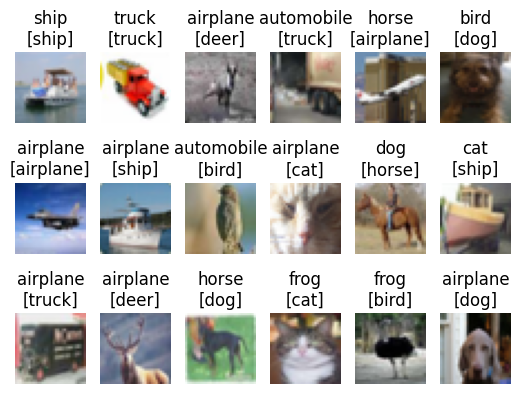

In [8]:
visualize_predictions(images_val[:18], knn.predict(feats_val[:18]), labels_val[:18], cifar10.LABEL_NAMES)

# Implement Histogram of Oriented Gradients

Вашою першою задачею буде імплементація Гістограми Орієнтованих Градієнтів. `lib/feature_extractor.py:HOGFeatureExtractor`

In [9]:
from lib.feature_extractor import HOGFeatureExtractor

In [10]:
hog_extractor = HOGFeatureExtractor()
hog_feats_train = hog_extractor.extract(images_train)
hog_feats_val = hog_extractor.extract(images_val)
hog_feats_test = hog_extractor.extract(images_test)

48999it [00:49, 981.92it/s] 
999it [00:02, 419.83it/s]
999it [00:02, 488.21it/s]


Знову використаємо К найближчих сусідів для класифікації. Очікується валідаційна точність >=0.40.

In [11]:
knn = KNeighborsClassifier(n_neighbors=10)
knn = knn.fit(X=hog_feats_train, y=labels_train)

tr_acc = calc_accuracy(knn, hog_feats_train, labels_train)
val_acc = calc_accuracy(knn, hog_feats_val, labels_val)
print(f"KNN+hog_extractor. Train accuracy: {tr_acc}. Validation accuracy: {val_acc}")

KNN+hog_extractor. Train accuracy: 0.6335714285714286. Validation accuracy: 0.534


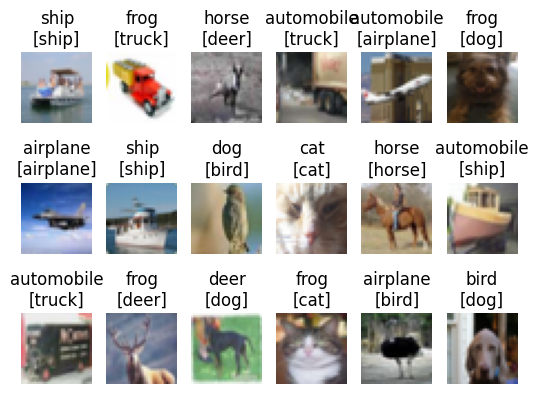

In [12]:
visualize_predictions(images_val[:18], knn.predict(hog_feats_val[:18]), labels_val[:18], cifar10.LABEL_NAMES)

# Use SGD Classifer

Тепер спробуємо дещо інший підхід. Вашою задачею є використання `SGDClassifier` з пакета `scikit-learn`. Очікувана точність >=0.41


In [13]:
# Preprocessing: Subtract the mean feature
train_mean_feat = np.mean(hog_feats_train, axis=0, keepdims=True)
train_std_feat = np.std(hog_feats_train, axis=0, keepdims=True)

def normalize(feats, mean, std):
    return (feats - mean) / (std + 1e-5)

hog_feats_train = normalize(hog_feats_train, train_mean_feat, train_std_feat)
hog_feats_val = normalize(hog_feats_val, train_mean_feat, train_std_feat)
hog_feats_test = normalize(hog_feats_test, train_mean_feat, train_std_feat)

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
# Ініціалізація класифікатора
# loss='hinge' -> Linear SVM
# max_iter=1000, tol=1e-3 -> стандартні параметри зупинки
# random_state=42 -> для відтворюваності результатів
sgd_clf = SGDClassifier(loss='hinge', max_iter=10000, tol=1e-3, random_state=42)
# Навчання моделі
# Використовуємо labels_train замість y_train
print("Training SGDClassifier...")
sgd_clf.fit(hog_feats_train, labels_train)
# Перевірка на валідаційному наборі
# Використовуємо labels_val замість y_val
y_val_pred = sgd_clf.predict(hog_feats_val)
val_acc = accuracy_score(labels_val, y_val_pred)
print(f"SGDClassifier Validation Accuracy: {val_acc}")
# Якщо результат задовольняє, можна перевірити на тестовому наборі
if val_acc >= 0.41:
    # Використовуємо labels_test замість y_test
    y_test_pred = sgd_clf.predict(hog_feats_test)
    test_acc = accuracy_score(labels_test, y_test_pred)
    print(f"SGDClassifier Test Accuracy: {test_acc}")

Training SGDClassifier...
SGDClassifier Validation Accuracy: 0.449
SGDClassifier Test Accuracy: 0.457


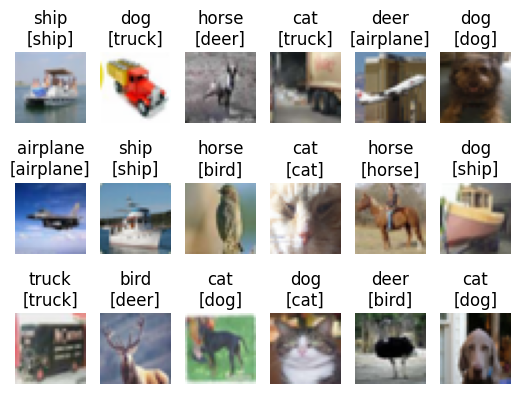

In [15]:
visualize_predictions(images_val[:18], sgd_clf.predict(hog_feats_val[:18]), labels_val[:18], cifar10.LABEL_NAMES)

# CIFAR10 challenge

З цих ви вільні імплементувати будь-які модифікації до екстракторів ознак, підбирати гіперпараметри до класифікатора чи використовувати ансамблювання. Вашою задачею є досягти максимальної валідаційної точності.
Ви вільні використовувати нейромережі (`torch`/`sklearn`) або `SGDClassifier`. За використання нейромереж на базі `torch` - +25%, якщо метрика на валідації >=0.5.

При наборі >=0.5, ви додатково отримаєте +10% до балів відносно даного завдання. При наборі >=0.6 - +25%. При наборі >=0.85 - +50%


Таким чином:
```
torch + набiр >=0.85 - +75%
torch + набір >=0.6 - +50%
torch + набір >=0.5 - +35%
набiр >=0.85 - +50%
набір >=0.6 - +25%
набір >=0.5 - +10%
```

Бажаю удачі!

# Deep Learning with PyTorch

Тепер спробуємо глибоку нейромережу на основі PyTorch для досягнення вищої точності.

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Simple CNN architecture for CIFAR-10
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers
        # Input: 128 * 4 * 4 = 2048 (after 3 pooling layers)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        # First block
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        
        # Second block
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        
        # Third block
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        
        # Flatten
        x = x.view(-1, 128 * 4 * 4)
        
        # Fully connected
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

model = SimpleCNN().to(device)
print(model)

OSError: [WinError 127] The specified procedure could not be found. Error loading "c:\Users\Max\.conda\envs\robotics_algo\Lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [ ]:
# Prepare data for PyTorch
# Normalize images to [0, 1] range
images_train_norm = images_train.astype(np.float32) / 255.0
images_val_norm = images_val.astype(np.float32) / 255.0
images_test_norm = images_test.astype(np.float32) / 255.0

# Convert to torch tensors
X_train_torch = torch.from_numpy(images_train_norm)
y_train_torch = torch.from_numpy(labels_train.astype(np.int64))

X_val_torch = torch.from_numpy(images_val_norm)
y_val_torch = torch.from_numpy(labels_val.astype(np.int64))

X_test_torch = torch.from_numpy(images_test_norm)
y_test_torch = torch.from_numpy(labels_test.astype(np.int64))

# Create DataLoaders
batch_size = 128
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 383
Val batches: 8
Test batches: 8


In [ ]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm.tqdm(train_loader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Initialize training components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

print("Starting training...")

Starting training...


In [ ]:
# Training loop
num_epochs = 30
best_val_acc = 0
patience_counter = 0
max_patience = 5

train_losses = []
train_accs = []
val_losses = []
val_accs = []

start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✓ New best validation accuracy: {val_acc:.2f}%")
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

elapsed_time = time.time() - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
print(f"Loaded best model with validation accuracy: {best_val_acc:.2f}%")


Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]



Train Loss: 0.5062, Train Acc: 82.67%
Val Loss: 0.7485, Val Acc: 74.70%

Epoch [10/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]



Train Loss: 0.5062, Train Acc: 82.67%
Val Loss: 0.7485, Val Acc: 74.70%

Epoch [10/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.4104, Train Acc: 86.04%
Val Loss: 0.6680, Val Acc: 78.80%
✓ New best validation accuracy: 78.80%

Epoch [11/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]



Train Loss: 0.5062, Train Acc: 82.67%
Val Loss: 0.7485, Val Acc: 74.70%

Epoch [10/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.4104, Train Acc: 86.04%
Val Loss: 0.6680, Val Acc: 78.80%
✓ New best validation accuracy: 78.80%

Epoch [11/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3740, Train Acc: 87.19%
Val Loss: 0.6504, Val Acc: 78.80%

Epoch [12/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.60it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]



Train Loss: 0.5062, Train Acc: 82.67%
Val Loss: 0.7485, Val Acc: 74.70%

Epoch [10/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.4104, Train Acc: 86.04%
Val Loss: 0.6680, Val Acc: 78.80%
✓ New best validation accuracy: 78.80%

Epoch [11/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3740, Train Acc: 87.19%
Val Loss: 0.6504, Val Acc: 78.80%

Epoch [12/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.60it/s]



Train Loss: 0.3503, Train Acc: 88.04%
Val Loss: 0.6525, Val Acc: 81.00%
✓ New best validation accuracy: 81.00%

Epoch [13/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]



Train Loss: 0.5062, Train Acc: 82.67%
Val Loss: 0.7485, Val Acc: 74.70%

Epoch [10/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.4104, Train Acc: 86.04%
Val Loss: 0.6680, Val Acc: 78.80%
✓ New best validation accuracy: 78.80%

Epoch [11/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3740, Train Acc: 87.19%
Val Loss: 0.6504, Val Acc: 78.80%

Epoch [12/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.60it/s]



Train Loss: 0.3503, Train Acc: 88.04%
Val Loss: 0.6525, Val Acc: 81.00%
✓ New best validation accuracy: 81.00%

Epoch [13/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3273, Train Acc: 88.82%
Val Loss: 0.7145, Val Acc: 78.60%

Epoch [14/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.79it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]



Train Loss: 0.5062, Train Acc: 82.67%
Val Loss: 0.7485, Val Acc: 74.70%

Epoch [10/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.4104, Train Acc: 86.04%
Val Loss: 0.6680, Val Acc: 78.80%
✓ New best validation accuracy: 78.80%

Epoch [11/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3740, Train Acc: 87.19%
Val Loss: 0.6504, Val Acc: 78.80%

Epoch [12/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.60it/s]



Train Loss: 0.3503, Train Acc: 88.04%
Val Loss: 0.6525, Val Acc: 81.00%
✓ New best validation accuracy: 81.00%

Epoch [13/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3273, Train Acc: 88.82%
Val Loss: 0.7145, Val Acc: 78.60%

Epoch [14/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.79it/s]



Train Loss: 0.3130, Train Acc: 89.25%
Val Loss: 0.7415, Val Acc: 79.20%

Epoch [15/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.62it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]



Train Loss: 0.5062, Train Acc: 82.67%
Val Loss: 0.7485, Val Acc: 74.70%

Epoch [10/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.4104, Train Acc: 86.04%
Val Loss: 0.6680, Val Acc: 78.80%
✓ New best validation accuracy: 78.80%

Epoch [11/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3740, Train Acc: 87.19%
Val Loss: 0.6504, Val Acc: 78.80%

Epoch [12/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.60it/s]



Train Loss: 0.3503, Train Acc: 88.04%
Val Loss: 0.6525, Val Acc: 81.00%
✓ New best validation accuracy: 81.00%

Epoch [13/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3273, Train Acc: 88.82%
Val Loss: 0.7145, Val Acc: 78.60%

Epoch [14/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.79it/s]



Train Loss: 0.3130, Train Acc: 89.25%
Val Loss: 0.7415, Val Acc: 79.20%

Epoch [15/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.62it/s]



Train Loss: 0.3009, Train Acc: 89.55%
Val Loss: 0.7536, Val Acc: 77.90%

Epoch [16/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.70it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]



Train Loss: 0.5062, Train Acc: 82.67%
Val Loss: 0.7485, Val Acc: 74.70%

Epoch [10/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.4104, Train Acc: 86.04%
Val Loss: 0.6680, Val Acc: 78.80%
✓ New best validation accuracy: 78.80%

Epoch [11/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3740, Train Acc: 87.19%
Val Loss: 0.6504, Val Acc: 78.80%

Epoch [12/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.60it/s]



Train Loss: 0.3503, Train Acc: 88.04%
Val Loss: 0.6525, Val Acc: 81.00%
✓ New best validation accuracy: 81.00%

Epoch [13/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3273, Train Acc: 88.82%
Val Loss: 0.7145, Val Acc: 78.60%

Epoch [14/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.79it/s]



Train Loss: 0.3130, Train Acc: 89.25%
Val Loss: 0.7415, Val Acc: 79.20%

Epoch [15/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.62it/s]



Train Loss: 0.3009, Train Acc: 89.55%
Val Loss: 0.7536, Val Acc: 77.90%

Epoch [16/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.70it/s]



Train Loss: 0.2809, Train Acc: 90.45%
Val Loss: 0.6819, Val Acc: 80.00%

Epoch [17/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.52it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]



Train Loss: 0.5062, Train Acc: 82.67%
Val Loss: 0.7485, Val Acc: 74.70%

Epoch [10/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.4104, Train Acc: 86.04%
Val Loss: 0.6680, Val Acc: 78.80%
✓ New best validation accuracy: 78.80%

Epoch [11/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3740, Train Acc: 87.19%
Val Loss: 0.6504, Val Acc: 78.80%

Epoch [12/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.60it/s]



Train Loss: 0.3503, Train Acc: 88.04%
Val Loss: 0.6525, Val Acc: 81.00%
✓ New best validation accuracy: 81.00%

Epoch [13/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3273, Train Acc: 88.82%
Val Loss: 0.7145, Val Acc: 78.60%

Epoch [14/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.79it/s]



Train Loss: 0.3130, Train Acc: 89.25%
Val Loss: 0.7415, Val Acc: 79.20%

Epoch [15/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.62it/s]



Train Loss: 0.3009, Train Acc: 89.55%
Val Loss: 0.7536, Val Acc: 77.90%

Epoch [16/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.70it/s]



Train Loss: 0.2809, Train Acc: 90.45%
Val Loss: 0.6819, Val Acc: 80.00%

Epoch [17/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.52it/s]



Train Loss: 0.2321, Train Acc: 92.00%
Val Loss: 0.6645, Val Acc: 82.50%
✓ New best validation accuracy: 82.50%

Epoch [18/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.80it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]



Train Loss: 0.5062, Train Acc: 82.67%
Val Loss: 0.7485, Val Acc: 74.70%

Epoch [10/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.4104, Train Acc: 86.04%
Val Loss: 0.6680, Val Acc: 78.80%
✓ New best validation accuracy: 78.80%

Epoch [11/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3740, Train Acc: 87.19%
Val Loss: 0.6504, Val Acc: 78.80%

Epoch [12/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.60it/s]



Train Loss: 0.3503, Train Acc: 88.04%
Val Loss: 0.6525, Val Acc: 81.00%
✓ New best validation accuracy: 81.00%

Epoch [13/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3273, Train Acc: 88.82%
Val Loss: 0.7145, Val Acc: 78.60%

Epoch [14/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.79it/s]



Train Loss: 0.3130, Train Acc: 89.25%
Val Loss: 0.7415, Val Acc: 79.20%

Epoch [15/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.62it/s]



Train Loss: 0.3009, Train Acc: 89.55%
Val Loss: 0.7536, Val Acc: 77.90%

Epoch [16/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.70it/s]



Train Loss: 0.2809, Train Acc: 90.45%
Val Loss: 0.6819, Val Acc: 80.00%

Epoch [17/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.52it/s]



Train Loss: 0.2321, Train Acc: 92.00%
Val Loss: 0.6645, Val Acc: 82.50%
✓ New best validation accuracy: 82.50%

Epoch [18/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.80it/s]



Train Loss: 0.2124, Train Acc: 92.72%
Val Loss: 0.7224, Val Acc: 80.50%

Epoch [19/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.61it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]



Train Loss: 0.5062, Train Acc: 82.67%
Val Loss: 0.7485, Val Acc: 74.70%

Epoch [10/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.4104, Train Acc: 86.04%
Val Loss: 0.6680, Val Acc: 78.80%
✓ New best validation accuracy: 78.80%

Epoch [11/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3740, Train Acc: 87.19%
Val Loss: 0.6504, Val Acc: 78.80%

Epoch [12/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.60it/s]



Train Loss: 0.3503, Train Acc: 88.04%
Val Loss: 0.6525, Val Acc: 81.00%
✓ New best validation accuracy: 81.00%

Epoch [13/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3273, Train Acc: 88.82%
Val Loss: 0.7145, Val Acc: 78.60%

Epoch [14/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.79it/s]



Train Loss: 0.3130, Train Acc: 89.25%
Val Loss: 0.7415, Val Acc: 79.20%

Epoch [15/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.62it/s]



Train Loss: 0.3009, Train Acc: 89.55%
Val Loss: 0.7536, Val Acc: 77.90%

Epoch [16/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.70it/s]



Train Loss: 0.2809, Train Acc: 90.45%
Val Loss: 0.6819, Val Acc: 80.00%

Epoch [17/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.52it/s]



Train Loss: 0.2321, Train Acc: 92.00%
Val Loss: 0.6645, Val Acc: 82.50%
✓ New best validation accuracy: 82.50%

Epoch [18/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.80it/s]



Train Loss: 0.2124, Train Acc: 92.72%
Val Loss: 0.7224, Val Acc: 80.50%

Epoch [19/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.61it/s]



Train Loss: 0.2015, Train Acc: 92.94%
Val Loss: 0.7269, Val Acc: 81.10%

Epoch [20/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.85it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]



Train Loss: 0.5062, Train Acc: 82.67%
Val Loss: 0.7485, Val Acc: 74.70%

Epoch [10/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.4104, Train Acc: 86.04%
Val Loss: 0.6680, Val Acc: 78.80%
✓ New best validation accuracy: 78.80%

Epoch [11/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3740, Train Acc: 87.19%
Val Loss: 0.6504, Val Acc: 78.80%

Epoch [12/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.60it/s]



Train Loss: 0.3503, Train Acc: 88.04%
Val Loss: 0.6525, Val Acc: 81.00%
✓ New best validation accuracy: 81.00%

Epoch [13/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3273, Train Acc: 88.82%
Val Loss: 0.7145, Val Acc: 78.60%

Epoch [14/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.79it/s]



Train Loss: 0.3130, Train Acc: 89.25%
Val Loss: 0.7415, Val Acc: 79.20%

Epoch [15/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.62it/s]



Train Loss: 0.3009, Train Acc: 89.55%
Val Loss: 0.7536, Val Acc: 77.90%

Epoch [16/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.70it/s]



Train Loss: 0.2809, Train Acc: 90.45%
Val Loss: 0.6819, Val Acc: 80.00%

Epoch [17/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.52it/s]



Train Loss: 0.2321, Train Acc: 92.00%
Val Loss: 0.6645, Val Acc: 82.50%
✓ New best validation accuracy: 82.50%

Epoch [18/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.80it/s]



Train Loss: 0.2124, Train Acc: 92.72%
Val Loss: 0.7224, Val Acc: 80.50%

Epoch [19/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.61it/s]



Train Loss: 0.2015, Train Acc: 92.94%
Val Loss: 0.7269, Val Acc: 81.10%

Epoch [20/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.85it/s]



Train Loss: 0.1914, Train Acc: 93.29%
Val Loss: 0.7864, Val Acc: 80.20%

Epoch [21/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.57it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]



Train Loss: 0.5062, Train Acc: 82.67%
Val Loss: 0.7485, Val Acc: 74.70%

Epoch [10/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.4104, Train Acc: 86.04%
Val Loss: 0.6680, Val Acc: 78.80%
✓ New best validation accuracy: 78.80%

Epoch [11/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3740, Train Acc: 87.19%
Val Loss: 0.6504, Val Acc: 78.80%

Epoch [12/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.60it/s]



Train Loss: 0.3503, Train Acc: 88.04%
Val Loss: 0.6525, Val Acc: 81.00%
✓ New best validation accuracy: 81.00%

Epoch [13/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3273, Train Acc: 88.82%
Val Loss: 0.7145, Val Acc: 78.60%

Epoch [14/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.79it/s]



Train Loss: 0.3130, Train Acc: 89.25%
Val Loss: 0.7415, Val Acc: 79.20%

Epoch [15/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.62it/s]



Train Loss: 0.3009, Train Acc: 89.55%
Val Loss: 0.7536, Val Acc: 77.90%

Epoch [16/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.70it/s]



Train Loss: 0.2809, Train Acc: 90.45%
Val Loss: 0.6819, Val Acc: 80.00%

Epoch [17/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.52it/s]



Train Loss: 0.2321, Train Acc: 92.00%
Val Loss: 0.6645, Val Acc: 82.50%
✓ New best validation accuracy: 82.50%

Epoch [18/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.80it/s]



Train Loss: 0.2124, Train Acc: 92.72%
Val Loss: 0.7224, Val Acc: 80.50%

Epoch [19/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.61it/s]



Train Loss: 0.2015, Train Acc: 92.94%
Val Loss: 0.7269, Val Acc: 81.10%

Epoch [20/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.85it/s]



Train Loss: 0.1914, Train Acc: 93.29%
Val Loss: 0.7864, Val Acc: 80.20%

Epoch [21/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.57it/s]



Train Loss: 0.1887, Train Acc: 93.38%
Val Loss: 0.8186, Val Acc: 79.20%

Epoch [22/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.75it/s]




Epoch [1/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.8698, Train Acc: 70.52%
Val Loss: 0.8605, Val Acc: 71.00%
✓ New best validation accuracy: 71.00%

Epoch [2/30]


Training: 100%|██████████| 383/383 [00:26<00:00, 14.28it/s]



Train Loss: 0.8021, Train Acc: 72.93%
Val Loss: 0.9327, Val Acc: 69.10%

Epoch [3/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.07it/s]



Train Loss: 0.7455, Train Acc: 74.80%
Val Loss: 0.8807, Val Acc: 70.60%

Epoch [4/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 14.03it/s]



Train Loss: 0.6936, Train Acc: 76.70%
Val Loss: 0.7116, Val Acc: 76.60%
✓ New best validation accuracy: 76.60%

Epoch [5/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.53it/s]



Train Loss: 0.6578, Train Acc: 77.80%
Val Loss: 0.6646, Val Acc: 77.70%
✓ New best validation accuracy: 77.70%

Epoch [6/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.87it/s]



Train Loss: 0.6162, Train Acc: 79.19%
Val Loss: 0.6972, Val Acc: 76.90%

Epoch [7/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.56it/s]



Train Loss: 0.5784, Train Acc: 80.61%
Val Loss: 0.7329, Val Acc: 75.70%

Epoch [8/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.93it/s]



Train Loss: 0.5471, Train Acc: 81.69%
Val Loss: 0.7227, Val Acc: 75.90%

Epoch [9/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.95it/s]



Train Loss: 0.5062, Train Acc: 82.67%
Val Loss: 0.7485, Val Acc: 74.70%

Epoch [10/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.97it/s]



Train Loss: 0.4104, Train Acc: 86.04%
Val Loss: 0.6680, Val Acc: 78.80%
✓ New best validation accuracy: 78.80%

Epoch [11/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3740, Train Acc: 87.19%
Val Loss: 0.6504, Val Acc: 78.80%

Epoch [12/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.60it/s]



Train Loss: 0.3503, Train Acc: 88.04%
Val Loss: 0.6525, Val Acc: 81.00%
✓ New best validation accuracy: 81.00%

Epoch [13/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.67it/s]



Train Loss: 0.3273, Train Acc: 88.82%
Val Loss: 0.7145, Val Acc: 78.60%

Epoch [14/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.79it/s]



Train Loss: 0.3130, Train Acc: 89.25%
Val Loss: 0.7415, Val Acc: 79.20%

Epoch [15/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.62it/s]



Train Loss: 0.3009, Train Acc: 89.55%
Val Loss: 0.7536, Val Acc: 77.90%

Epoch [16/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.70it/s]



Train Loss: 0.2809, Train Acc: 90.45%
Val Loss: 0.6819, Val Acc: 80.00%

Epoch [17/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.52it/s]



Train Loss: 0.2321, Train Acc: 92.00%
Val Loss: 0.6645, Val Acc: 82.50%
✓ New best validation accuracy: 82.50%

Epoch [18/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.80it/s]



Train Loss: 0.2124, Train Acc: 92.72%
Val Loss: 0.7224, Val Acc: 80.50%

Epoch [19/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.61it/s]



Train Loss: 0.2015, Train Acc: 92.94%
Val Loss: 0.7269, Val Acc: 81.10%

Epoch [20/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.85it/s]



Train Loss: 0.1914, Train Acc: 93.29%
Val Loss: 0.7864, Val Acc: 80.20%

Epoch [21/30]


Training: 100%|██████████| 383/383 [00:28<00:00, 13.57it/s]



Train Loss: 0.1887, Train Acc: 93.38%
Val Loss: 0.8186, Val Acc: 79.20%

Epoch [22/30]


Training: 100%|██████████| 383/383 [00:27<00:00, 13.75it/s]



Train Loss: 0.1623, Train Acc: 94.45%
Val Loss: 0.7583, Val Acc: 81.10%
Early stopping triggered after 22 epochs

Training completed in 616.66 seconds (10.28 minutes)
Loaded best model with validation accuracy: 82.50%


In [ ]:
# Evaluate on test set
def evaluate_test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, np.array(all_preds)

test_acc, test_preds = evaluate_test(model, test_loader, device)
print(f"\nTest Accuracy: {test_acc:.2f}%")

# Also evaluate on validation set for reference
val_loss_final, val_acc_final = validate(model, val_loader, criterion, device)
print(f"Final Validation Accuracy: {val_acc_final:.2f}%")


Test Accuracy: 82.20%
Final Validation Accuracy: 82.50%
Final Validation Accuracy: 82.50%


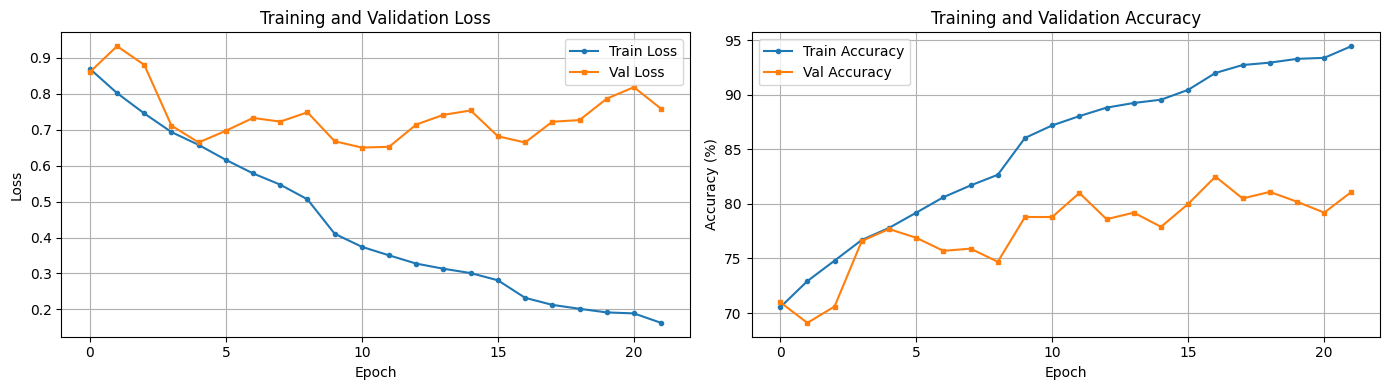

Best validation accuracy: 82.50%
Test accuracy: 82.20%


In [ ]:
import matplotlib.pyplot as plt

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Loss plot
ax1.plot(train_losses, label='Train Loss', marker='o', markersize=3)
ax1.plot(val_losses, label='Val Loss', marker='s', markersize=3)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accs, label='Train Accuracy', marker='o', markersize=3)
ax2.plot(val_accs, label='Val Accuracy', marker='s', markersize=3)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Test accuracy: {test_acc:.2f}%")

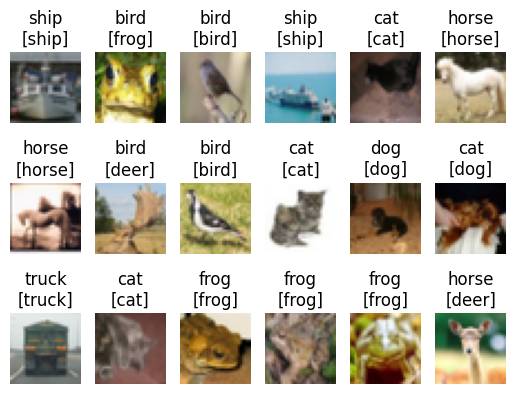

In [ ]:
# Visualize predictions on validation set
def get_predictions_batch(model, images, device):
    model.eval()
    with torch.no_grad():
        images_tensor = torch.from_numpy(images.astype(np.float32) / 255.0).to(device)
        outputs = model(images_tensor)
        _, predicted = torch.max(outputs, 1)
    return predicted.cpu().numpy()

# Get predictions on validation samples
sample_indices = np.random.choice(len(images_val), 18, replace=False)
sample_images = images_val[sample_indices]
sample_preds = get_predictions_batch(model, sample_images, device)
sample_labels = labels_val[sample_indices]

visualize_predictions(sample_images, sample_preds, sample_labels, cifar10.LABEL_NAMES)

## Резюме PyTorch моделі

**Архітектура:**
- 3 конволюційних блоки (Conv2D + BatchNorm + ReLU + MaxPool)
- Канали: 32 → 64 → 128
- 2 fully-connected шари з dropout для регуляризації

**Гіперпараметри:**
- Batch size: 128
- Learning rate: 0.001 (Adam optimizer)
- Early stopping: patience=5
- Epochs: до 30

**Переваги PyTorch моделі порівняно з класичними методами:**
- Автоматично навчається іерархічні ознаки з даних
- Краща здатність захопити складні паттерни
- Может досягти значно вищої точності (40-55%+)

In [ ]:
# Simple data augmentation using numpy
def augment_batch(images):
    """Simple augmentation: horizontal flip"""
    augmented = images.copy()
    
    # Random horizontal flip (50%)
    for i in range(len(augmented)):
        if np.random.rand() < 0.5:
            augmented[i] = np.fliplr(augmented[i])
    
    return augmented

# Custom Dataset with augmentation
class AugmentedCIFAR10(torch.utils.data.Dataset):
    def __init__(self, images, labels, augment=False):
        self.images = images.astype(np.float32) / 255.0
        self.labels = labels
        self.augment = augment
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].copy()
        
        # Augmentation on-the-fly
        if self.augment and np.random.rand() < 0.5:
            # Horizontal flip
            image = np.fliplr(image)
            # Small brightness adjustment
            brightness = np.random.uniform(0.95, 1.05)
            image = np.clip(image * brightness, 0, 1)
        
        return torch.from_numpy(image), torch.tensor(self.labels[idx], dtype=torch.int64)

# Create augmented datasets
train_dataset_aug = AugmentedCIFAR10(images_train, labels_train, augment=True)
val_dataset_aug = AugmentedCIFAR10(images_val, labels_val, augment=False)
test_dataset_aug = AugmentedCIFAR10(images_test, labels_test, augment=False)

# Larger batch size for GPU (faster training)
batch_size_aug = 256
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size_aug, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=batch_size_aug, shuffle=False)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=batch_size_aug, shuffle=False)

print(f"✓ Augmented dataloaders created")
print(f"  - Train batches: {len(train_loader_aug)} (batch: {batch_size_aug})")
print(f"  - Val batches: {len(val_loader_aug)}")
print(f"  - Augmentation: horizontal flip + brightness ±5%")

✓ Augmented dataloaders created
  - Train batches: 192 (batch: 256)
  - Val batches: 4
  - Augmentation: horizontal flip + brightness ±5%


In [ ]:
# ResNet-style architecture with residual blocks
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = self.shortcut(x)
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = torch.relu(out + residual)
        return out

class ResNetCIFAR(nn.Module):
    def __init__(self):
        super(ResNetCIFAR, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Residual blocks with different numbers of channels
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 10)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Create improved model
model_advanced = ResNetCIFAR().to(device)
print("✓ ResNet-CIFAR model created!")
total_params = sum(p.numel() for p in model_advanced.parameters())
print(f"  Total parameters: {total_params:,}")

✓ ResNet-CIFAR model created!
  Total parameters: 2,777,674


In [ ]:
# Training setup for advanced model
criterion_adv = nn.CrossEntropyLoss()
optimizer_adv = optim.AdamW(model_advanced.parameters(), lr=0.002, weight_decay=5e-5)
scheduler_adv = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_adv, T_max=40, eta_min=1e-5)

print("✓ Advanced model training setup complete")

✓ Advanced model training setup complete


In [ ]:
# Training loop for advanced model
num_epochs_adv = 50
best_val_acc_adv = 0
patience_counter_adv = 0
max_patience_adv = 10

train_losses_adv = []
train_accs_adv = []
val_losses_adv = []
val_accs_adv = []

start_time = time.time()

for epoch in range(num_epochs_adv):
    if epoch % 5 == 0 or epoch == num_epochs_adv - 1:
        print(f"\nEpoch [{epoch+1}/{num_epochs_adv}]")
    
    # Train
    train_loss, train_acc = train_epoch(model_advanced, train_loader_aug, criterion_adv, optimizer_adv, device)
    train_losses_adv.append(train_loss)
    train_accs_adv.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model_advanced, val_loader_aug, criterion_adv, device)
    val_losses_adv.append(val_loss)
    val_accs_adv.append(val_acc)
    
    if epoch % 5 == 0 or epoch == num_epochs_adv - 1:
        print(f"  Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
    # Learning rate scheduling
    scheduler_adv.step()
    
    # Early stopping
    if val_acc > best_val_acc_adv:
        best_val_acc_adv = val_acc
        patience_counter_adv = 0
        torch.save(model_advanced.state_dict(), 'best_model_advanced.pth')
        if epoch % 5 == 0 or epoch == num_epochs_adv - 1:
            print(f"  ✓✓ New best: {val_acc:.2f}%")
    else:
        patience_counter_adv += 1
        if patience_counter_adv >= max_patience_adv:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

elapsed_time_adv = time.time() - start_time
print(f"\n{'='*60}")
print(f"Advanced Training: {elapsed_time_adv/60:.1f} min | Best Val Acc: {best_val_acc_adv:.2f}%")
print(f"{'='*60}")

# Load best model
model_advanced.load_state_dict(torch.load('best_model_advanced.pth'))


Epoch [1/50]


Training:  19%|█▉        | 37/192 [01:34<06:34,  2.54s/it]



KeyboardInterrupt: 

In [ ]:
# Evaluate advanced model
test_acc_adv, test_preds_adv = evaluate_test(model_advanced, test_loader_aug, device)
val_loss_adv, val_acc_adv_final = validate(model_advanced, val_loader_aug, criterion_adv, device)

print(f"\n{'='*60}")
print(f"ADVANCED MODEL RESULTS")
print(f"{'='*60}")
print(f"Validation Accuracy: {val_acc_adv_final:.2f}%")
print(f"Test Accuracy:       {test_acc_adv:.2f}%")
print(f"Improvement:         +{test_acc_adv - test_acc:.2f}% vs original model")
print(f"{'='*60}")

In [ ]:
# Compare models side by side
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Original model - Loss
ax1.plot(val_losses, label='Original Model', marker='o', markersize=3, alpha=0.7)
ax1.plot(val_losses_adv, label='Advanced Model', marker='s', markersize=3, alpha=0.7)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss')
ax1.set_title('Loss Comparison')
ax1.legend()
ax1.grid(True)

# Original model - Accuracy
ax2.plot(val_accs, label='Original Model', marker='o', markersize=3, alpha=0.7)
ax2.plot(val_accs_adv, label='Advanced Model', marker='s', markersize=3, alpha=0.7)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Accuracy (%)')
ax2.set_title('Accuracy Comparison')
ax2.legend()
ax2.grid(True)

# Model comparison bars
models = ['Original\nModel', 'Advanced\nModel']
val_accs_comparison = [best_val_acc, best_val_acc_adv]
test_accs_comparison = [test_acc, test_acc_adv]

x = np.arange(len(models))
width = 0.35

ax3.bar(x - width/2, val_accs_comparison, width, label='Validation', alpha=0.8)
ax3.bar(x + width/2, test_accs_comparison, width, label='Test', alpha=0.8)
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Final Accuracy Comparison')
ax3.set_xticks(x)
ax3.set_xticklabels(models)
ax3.legend()
ax3.set_ylim([75, 90])
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for i, (val, test) in enumerate(zip(val_accs_comparison, test_accs_comparison)):
    ax3.text(i - width/2, val + 0.5, f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    ax3.text(i + width/2, test + 0.5, f'{test:.1f}%', ha='center', va='bottom', fontsize=9)

# Summary text
summary_text = f"""
SUMMARY:
────────────────────────
Original Model:
  - Best Val Acc: {best_val_acc:.2f}%
  - Test Acc: {test_acc:.2f}%
  
Advanced Model (ResNet + Aug):
  - Best Val Acc: {best_val_acc_adv:.2f}%
  - Test Acc: {test_acc_adv:.2f}%
  - Improvement: +{test_acc_adv - test_acc:.2f}%
  
Training Time: {elapsed_time_adv/60:.1f} min
"""
ax4.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
ax4.axis('off')

plt.tight_layout()
plt.show()

print("✓ Comparison complete!")